## Datasets
- Os dados sobre Bitcoin, Ibovespa,VIX e Dolar foram obtido no site Yahoo Finance
- Taxa Selic - Dados diários;Filtros aplicados: Data inicial: 01/11/2013 / Data final: 02/09/2022. <br>
LINK https://www.bcb.gov.br/htms/SELIC/SELICdiarios.asp?frame=1

In [1]:
# import numpy as np
import pandas as pd
# import math
from pandas_datareader import data as wb
# import matplotlib.pyplot as plt
# from datetime import datetime
# from pytz import timezone

# from forex_python.converter import CurrencyRates
# c = CurrencyRates()
# cambio = c.get_rate('USD', 'BRL')

# INVESTIMENTOSEXTERIOR = 1500#REAL
# CAIXAEXTERNO = 0.58 #DOLAR

# IVVB11 = wb.DataReader('IVVB11.SA', data_source='yahoo', start='2010-1-1 00:00:00')
# BVSP = wb.DataReader('^BVSP', 'av-intraday', data_source='yahoo', start='2010-1-1 00:00:00',)
# BVSP

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

### Constants and Parameters

In [3]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TRAIN_BEGIN = '2017.08.01'
TRAIN_END = '2020.05.31'
TEST_BEGIN = '2020.06.01'
TEST_END = '2021.06.01'

TIMES = 3

### Auxiliary functions

In [4]:
def calculateEMA(df, n, columns):
    """
    returns an n period exponential moving average for
    the time series s

    pd.Dataframe df: is the original dataframe - it needs to contain a 'Close' named column
    int          n: is the number of periods to consider in the calculus

    returns a dataframe with a new column containing the MME
    """
    
    k  = 2 / (n+1)
    for column in columns:
        EMAcolumn = 'EMA_'+column

        df[EMAcolumn] = df[column]
        df[EMAcolumn].iloc[n-1] = df[column].iloc[0:n-2].mean()

        for i in range(n, len(df)):
            df[EMAcolumn].iloc[i] = (df[column].iloc[i] - df[EMAcolumn].iloc[i-1])*k + df[EMAcolumn].iloc[i-1]
            #MME = (Close[i] - MME[i-1])*k + MME[i-1] 
     
    #The following function makes all the hardwork. However I'll keep it commented, once I've already implemented the calculation
    #f['pandasEMA'] = df['close'].ewm(span=5, adjust=False).mean()
    
    return df

def calculateBB(df, n, columns):
    for column in columns:
        ma = df['close'].rolling(window=n).mean()
        std = df['close'].rolling(window=n).std() 
    
        df['UB_'+column] = ma + (std * 2)
        df['LB_'+column] = ma - (std * 2)
    
    return df

def removeColumns(df, columns):
    df = df.drop(columns, axis=1)
    return df

def addPreviousDays(df, days, columns):
    auxDf = df
    for day in range(1,days+1):
        for column in columns:
            colName = 'd-'+str(day)+'_'+column
            df[colName] = auxDf[column].shift(day)
    return df

def getPeriod(df, begin, end, resetIndex = False):
    """
    returns the df in the chosen interval
    
    Object begin: Start date forrmated as 'yyyy.mm.dd'
    Object   end: end date 'yyyy.mm.dd'

    returns a dataframe with the historic of the selected period
    """
    indexBegin = df[df['date']>=begin].index[0]
    indexEnd = df[df['date']>=end].index[0]
    if (resetIndex):
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)].reset_index(drop=True)
    else: 
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)]
    
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100, np.std(np.abs((actual - pred) / actual)) * 100

def mae(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs(actual - pred)), np.std(np.abs(actual - pred))

def Normalize(df):
    date = df['date']
    maxVal = df[['high', 'low']].max()
    normalized = removeColumns(df,['date'])/(removeColumns(df,['date']).max()*2)
    
    
    df.loc[:, df.columns != 'date'] = normalized
    
    return df, maxVal

def createDate(day, month, year):
    if(day >= 10):
        day = str(day)
    else:
        day = '0' + str(day)
    
    if(month < 10):
        month = '0' + str(month)
    else:
        month = str(month)
        
    year = str(year)
    date = year + '.' + month + '.' + day
    
    return date

def getDate(date):
    
    split = date.split('.')
    
    year = int(split[0])
    month = int(split[1])
    day = int(split[2])
    
    return year, month, day
 
def printResult(error, column):
    print(column+': '+str(error[0].round(2))+' +- '+str(error[1].round(2)) + ' %')

### Opening the dataset

In [5]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df2 = pd.read_csv('../Data/VALE3_Daily.csv', sep = "\t")

df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

# df 
df.tail(290)


date   open   high    low  close
1049  2020.03.31  13.16  14.07  13.16  13.54
1050  2020.04.01  13.01  14.08  12.89  13.84
1051  2020.04.02  14.90  16.01  14.52  15.01
1052  2020.04.03  15.77  15.83  14.44  14.84
1053  2020.04.06  15.53  15.58  14.69  15.26
...          ...    ...    ...    ...    ...
1334  2021.05.26  25.91  26.18  25.65  26.09
1335  2021.05.27  26.08  26.25  25.77  25.91
1336  2021.05.28  26.20  27.02  26.15  26.99
1337  2021.05.31  26.96  27.20  26.78  26.87
1338  2021.06.01  27.40  27.70  27.01  27.29

[290 rows x 5 columns]

In [5]:
df2.tail(30)

date    open    high     low   close
1309  2021.04.20  107.95  108.35  105.02  106.16
1310  2021.04.22  107.24  107.24  104.34  106.23
1311  2021.04.23  107.15  108.10  106.46  107.99
1312  2021.04.26  109.95  110.69  108.15  108.57
1313  2021.04.27  108.88  110.60  108.52  110.12
1314  2021.04.28  110.56  112.43  109.33  111.92
1315  2021.04.29  112.19  112.95  110.89  111.95
1316  2021.04.30  110.99  111.56  109.02  109.02
1317  2021.05.03  109.70  110.35  108.26  108.46
1318  2021.05.04  108.95  111.07  108.66  110.10
1319  2021.05.05  111.99  112.82  110.39  110.71
1320  2021.05.06  111.94  115.20  111.48  115.05
1321  2021.05.07  116.54  116.55  114.19  115.45
1322  2021.05.10  119.80  120.45  114.69  114.69
1323  2021.05.11  113.98  118.72  113.32  118.72
1324  2021.05.12  118.00  118.46  113.96  114.33
1325  2021.05.13  112.00  114.22  110.72  112.49
1326  2021.05.14  111.20  111.79  109.62  110.56
1327  2021.05.17  111.50  113.82  111.17  113.46
1328  2021.05.18  114.56  115.40  113.19  114.60
1329  2021.05.19  112.10  112.78  109.84  112.25
1330  2021.05.20  111.70  112.10  110.20  111.11
1331  2021.05.21  111.11  111.25  108.50  109.40
1332  2021.05.24  108.00  110.14  107.51  109.78
1333  2021.05.25  110.28  110.89  106.78  107.05
1334  2021.05.26  106.37  110.32  106.03  110.20
1335  2021.05.27  110.80  112.09  109.77  110.99
1336  2021.05.28  111.11  112.75  109.42  111.59
1337  2021.05.31  112.50  114.89  112.50  114.78
1338  2021.06.01  117.00  118.00  113.20  113.20

In [6]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

#VALE3
df2 = calculateEMA(df2,DAYS,newColumns)
df2 = calculateBB(df2,DAYS,newColumns)
df2 = addPreviousDays(df2,DAYS, newColumns)

In [7]:
print(df.columns, df.columns.size)
print(df2.columns, df2.columns.size)

Index(['date', 'open', 'high', 'low', 'close', 'EMA_open', 'EMA_high',
       'EMA_low', 'EMA_close', 'UB_open', 'LB_open', 'UB_high', 'LB_high',
       'UB_low', 'LB_low', 'UB_close', 'LB_close', 'd-1_open', 'd-1_high',
       'd-1_low', 'd-1_close', 'd-2_open', 'd-2_high', 'd-2_low', 'd-2_close',
       'd-3_open', 'd-3_high', 'd-3_low', 'd-3_close', 'd-4_open', 'd-4_high',
       'd-4_low', 'd-4_close', 'd-5_open', 'd-5_high', 'd-5_low', 'd-5_close'],
      dtype='object') 37
Index(['date', 'open', 'high', 'low', 'close', 'EMA_open', 'EMA_high',
       'EMA_low', 'EMA_close', 'UB_open', 'LB_open', 'UB_high', 'LB_high',
       'UB_low', 'LB_low', 'UB_close', 'LB_close', 'd-1_open', 'd-1_high',
       'd-1_low', 'd-1_close', 'd-2_open', 'd-2_high', 'd-2_low', 'd-2_close',
       'd-3_open', 'd-3_high', 'd-3_low', 'd-3_close', 'd-4_open', 'd-4_high',
       'd-4_low', 'd-4_close', 'd-5_open', 'd-5_high', 'd-5_low', 'd-5_close'],
      dtype='object') 37


In [7]:
# TRAIN_BEGIN = '2017.08.01'
# TRAIN_END = '2020.05.31'
# TEST_BEGIN = '2020.06.01'
# TEST_END = '2021.06.01'


# initialDf_PETR4 = getPeriod(df, '2019.01.02','2021.06.01', True)
# initialDf_VALE3 = getPeriod(df2, '2019.01.02','2021.06.01', True)
initialDf_PETR4 = getPeriod(df, TRAIN_BEGIN,TEST_END, True)
initialDf_VALE3 = getPeriod(df2, TRAIN_BEGIN,TEST_END, True)

In [8]:
# print(initialDf_PETR4)
# print(initialDf_VALE3)
print(initialDf_PETR4.columns, df.columns.size)
# print(initialDf_VALE3.columns, df2.columns.size)

Index(['date', 'open', 'high', 'low', 'close', 'EMA_open', 'EMA_high',
       'EMA_low', 'EMA_close', 'UB_open', 'LB_open', 'UB_high', 'LB_high',
       'UB_low', 'LB_low', 'UB_close', 'LB_close', 'd-1_open', 'd-1_high',
       'd-1_low', 'd-1_close', 'd-2_open', 'd-2_high', 'd-2_low', 'd-2_close',
       'd-3_open', 'd-3_high', 'd-3_low', 'd-3_close', 'd-4_open', 'd-4_high',
       'd-4_low', 'd-4_close', 'd-5_open', 'd-5_high', 'd-5_low', 'd-5_close'],
      dtype='object') 37


In [10]:
# obtendo indicadores externos
def allColumnsToLower(df):
    columnHash = {}
    for columnName in df.columns:
        columnHash[columnName] = columnName.lower()
    df = df.rename(columnHash, axis=1) 
    return df

def parseDate(str:str):
    return str.replace('-','.')

df_VIX = pd.read_csv('../Data/externalIndex/^VIX.csv', sep = ",")
df_VIX = df_VIX.dropna()
df_VIX = allColumnsToLower(df_VIX)
df_VIX = removeColumns(df_VIX, ['adj close', 'volume'])
df_VIX['date'] = df_VIX['date'].map(parseDate)

df_BVSP = pd.read_csv('../Data/externalIndex/^BVSP.csv', sep = ",")
df_BVSP = df_BVSP.dropna()
df_BVSP = allColumnsToLower(df_BVSP)
df_BVSP = removeColumns(df_BVSP, ['adj close', 'volume'])
df_BVSP['date'] = df_BVSP['date'].map(parseDate)

df_DOLAR = pd.read_csv('../Data/externalIndex/BRL=X.csv', sep = ",")
df_DOLAR = df_DOLAR.dropna()
df_DOLAR = allColumnsToLower(df_DOLAR)
df_DOLAR = removeColumns(df_DOLAR, ['adj close', 'volume'])
df_DOLAR['date'] = df_DOLAR['date'].map(parseDate)

df_BTC = pd.read_csv('../Data/externalIndex/BTC-USD.csv', sep = ",")
df_BTC = df_BTC.dropna()
df_BTC = allColumnsToLower(df_BTC)
df_BTC = removeColumns(df_BTC, ['adj close', 'volume'])
df_BTC['date'] = df_BTC['date'].map(parseDate)




In [11]:
#VIX
df_VIX = calculateEMA(df_VIX,DAYS,newColumns)
df_VIX = calculateBB(df_VIX,DAYS,newColumns)
df_VIX = addPreviousDays(df_VIX,DAYS, newColumns)

#DOLAR
df_DOLAR = calculateEMA(df_DOLAR,DAYS,newColumns)
df_DOLAR = calculateBB(df_DOLAR,DAYS,newColumns)
df_DOLAR = addPreviousDays(df_DOLAR,DAYS, newColumns)

#IBOVESPA
df_BVSP = calculateEMA(df_BVSP,DAYS,newColumns)
df_BVSP = calculateBB(df_BVSP,DAYS,newColumns)
df_BVSP = addPreviousDays(df_BVSP,DAYS, newColumns)

#BITCOIN
df_BTC = calculateEMA(df_BTC,DAYS,newColumns)
df_BTC = calculateBB(df_BTC,DAYS,newColumns)
df_BTC = addPreviousDays(df_BTC,DAYS, newColumns)



#### Experimento 01: Utilizando Random Forest Sem indicadores externos
##### Hipóteses plausíveis de serem testadas
1. Se construirmos um regressor só para a baixa e um regressor só para alta melhoramos nossa precisão?

In [12]:
def exp1(df, inputColumns = [], printPredictValues = False, runBackTesting = False, **regressorParams):
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        trainColumns = [column for column in inputColumns if not column in ['date']]
        x_train = df_train[trainColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]


    rf = RandomForestRegressor(n_estimators = 500, **regressorParams)
    rf.fit(x_train, y_train);

    y_pred = rf.predict(x_test)

    
    if printPredictValues:
        # plotting the points
        plt.figure(figsize=(10,5),dpi = 1000)
        
        plt.plot(x_train.index, y_train['low'], label='real-low', color='tab:red', lw = 0.3)
        plt.plot(x_train.index, y_train['high'], label='real-high', color='tab:green', lw = 0.3)
        plt.axvline(x = x_train.index.size, color = 'b', label = 'train|test', lw = 0.3)

        plt.plot(x_test.index, y_test['low'], label='real-low', color='tab:red', lw = 0.3)
        plt.plot(x_test.index, y_test['high'], label='real-high', color='tab:green', lw = 0.3)
        plt.plot(x_test.index, y_pred[:,1], label='pred-low', color='tab:red', linestyle='dotted', lw = 0.3)
        plt.plot(x_test.index, y_pred[:,0], label='pred-high', color='tab:green', linestyle='dotted', lw = 0.3)
        # plt.plot(x_test.index, y_pred)    
        plt.xlabel('x - axis')
        plt.ylabel('y - axis')
        plt.title('Valor Predito e Valor Real')
        
        # function to show the plot
        plt.legend()
        plt.show()
        
    if runBackTesting:
        pass
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    
    resultTest = df_test
    resultTest['pred_low'] = y_pred[:,1]
    resultTest['pred_high'] = y_pred[:,0]
    return errorMax, errorMin, rf, x_train.columns, resultTest

In [13]:
initialDf_PETR4

date   open   high    low  close   EMA_open   EMA_high    EMA_low  \
0    2017.08.01  12.06  12.08  11.86  11.90  11.941241  12.016120  11.797504   
1    2017.08.02  11.91  12.34  11.86  12.25  11.930827  12.124080  11.818336   
2    2017.08.03  12.31  12.39  12.07  12.07  12.057218  12.212720  11.902224   
3    2017.08.04  12.16  12.23  12.03  12.15  12.091479  12.218480  11.944816   
4    2017.08.07  12.11  12.35  12.09  12.29  12.097653  12.262320  11.993211   
..          ...    ...    ...    ...    ...        ...        ...        ...   
941  2021.05.26  25.91  26.18  25.65  26.09  26.114791  26.354219  25.760657   
942  2021.05.27  26.08  26.25  25.77  25.91  26.103194  26.319479  25.763771   
943  2021.05.28  26.20  27.02  26.15  26.99  26.135462  26.552986  25.892514   
944  2021.05.31  26.96  27.20  26.78  26.87  26.410308  26.768657  26.188343   
945  2021.06.01  27.40  27.70  27.01  27.29  26.740206  27.079105  26.462229   

     EMA_close    UB_open  ...  d-3_low  d-3_close  d-4_open  d-4_high  \
0    11.901463  12.108321  ...    11.79      11.79     12.06     12.10   
1    12.017642  12.333836  ...    11.71      11.91     11.84     11.94   
2    12.035095  12.321517  ...    11.85      12.05     11.77     11.91   
3    12.073397  12.343075  ...    11.86      11.90     11.99     12.07   
4    12.145598  12.443256  ...    11.86      12.25     12.06     12.08   
..         ...        ...  ...      ...        ...       ...       ...   
941  26.042263  26.470349  ...    25.94      25.95     26.15     26.28   
942  25.998175  26.471798  ...    25.99      26.39     26.08     26.31   
943  26.328784  27.180120  ...    25.78      25.84     26.28     26.52   
944  26.509189  27.435810  ...    25.65      26.09     26.48     26.62   
945  26.769459  27.826996  ...    25.77      25.91     25.91     26.18   

     d-4_low  d-4_close  d-5_open  d-5_high  d-5_low  d-5_close  
0      11.77      11.77     11.80     12.02    11.80      11.99  
1      11.79      11.79     12.06     12.10    11.77      11.77  
2      11.71      11.91     11.84     11.94    11.79      11.79  
3      11.85      12.05     11.77     11.91    11.71      11.91  
4      11.86      11.90     11.99     12.07    11.85      12.05  
..       ...        ...       ...       ...      ...        ...  
941    25.72      25.93     25.85     26.35    25.80      26.15  
942    25.94      25.95     26.15     26.28    25.72      25.93  
943    25.99      26.39     26.08     26.31    25.94      25.95  
944    25.78      25.84     26.28     26.52    25.99      26.39  
945    25.65      26.09     26.48     26.62    25.78      25.84  

[946 rows x 37 columns]

In [14]:
initialDf_VALE3

date    open    high     low   close    EMA_open    EMA_high  \
0    2017.08.01   27.34   27.34   26.86   27.18   26.786155   27.011392   
1    2017.08.02   26.86   27.36   26.72   27.22   26.810770   27.127595   
2    2017.08.03   27.25   27.33   26.81   26.84   26.957180   27.195063   
3    2017.08.04   27.09   27.55   26.90   27.33   27.001453   27.313375   
4    2017.08.07   27.65   28.38   27.64   28.37   27.217635   27.668917   
..          ...     ...     ...     ...     ...         ...         ...   
941  2021.05.26  106.37  110.32  106.03  110.20  109.166674  111.131617   
942  2021.05.27  110.80  112.09  109.77  110.99  109.711116  111.451078   
943  2021.05.28  111.11  112.75  109.42  111.59  110.177411  111.884052   
944  2021.05.31  112.50  114.89  112.50  114.78  110.951607  112.886035   
945  2021.06.01  117.00  118.00  113.20  113.20  112.967738  114.590690   

        EMA_low   EMA_close     UB_open  ...  d-3_low  d-3_close  d-4_open  \
0     26.373609   26.767543   27.937474  ...    25.61      25.99     27.04   
1     26.489072   26.918362   28.034640  ...    25.66      26.55     25.95   
2     26.596048   26.892241   27.710181  ...    27.16      27.39     25.84   
3     26.697365   27.038161   27.619878  ...    26.86      27.18     27.56   
4     27.011577   27.482107   28.545359  ...    26.72      27.22     27.34   
..          ...         ...         ...  ...      ...        ...       ...   
941  107.622606  109.807900  112.536643  ...   108.50     109.40    111.70   
942  108.338404  110.201933  112.450432  ...   107.51     109.78    111.11   
943  108.698936  110.664622  113.424668  ...   106.78     107.05    108.00   
944  109.965957  112.036415  116.476159  ...   106.03     110.20    110.28   
945  111.043972  112.424276  115.823659  ...   109.77     110.99    106.37   

     d-4_high  d-4_low  d-4_close  d-5_open  d-5_high  d-5_low  d-5_close  
0       27.04    25.94      25.95     25.86     26.82    25.86      26.78  
1       26.43    25.61      25.99     27.04     27.04    25.94      25.95  
2       26.56    25.66      26.55     25.95     26.43    25.61      25.99  
3       27.58    27.16      27.39     25.84     26.56    25.66      26.55  
4       27.34    26.86      27.18     27.56     27.58    27.16      27.39  
..        ...      ...        ...       ...       ...      ...        ...  
941    112.10   110.20     111.11    112.10    112.78   109.84     112.25  
942    111.25   108.50     109.40    111.70    112.10   110.20     111.11  
943    110.14   107.51     109.78    111.11    111.25   108.50     109.40  
944    110.89   106.78     107.05    108.00    110.14   107.51     109.78  
945    110.32   106.03     110.20    110.28    110.89   106.78     107.05  

[946 rows x 37 columns]

In [36]:

def runModelNTimes(df, phrase, columnInput = [], times = TIMES):
    errorsMax = []
    errorsMin = []
    for i in range(1, times+1):
        if(columnInput == []):
            errorMax, errorMin, rf, _, _  = exp1(df)
        else: 
            errorMax, errorMin, rf, _ , _= exp1(df, columnInput)
            
        errorsMax.append(errorMax[0])
        errorsMin.append(errorMin[0])
        
    
    errorsMax = np.array(errorsMax)
    errorsMin = np.array(errorsMin)
    print(phrase)
    printResult((errorsMax.mean(),errorsMax.std()), 'High')
    printResult((errorsMin.mean(),errorsMin.std()), 'Low')
    
runModelNTimes(initialDf_PETR4, 'PETR4 15 Variables', col15) 
runModelNTimes(initialDf_PETR4, 'PETR4 25 Variables', col25) 
runModelNTimes(initialDf_PETR4, 'PETR4 33 Variables') 
print('\n')
# runModelNTimes(initialDf_VALE3, 'VALE3 15 Variables', col15) 
# runModelNTimes(initialDf_VALE3, 'VALE3 25 Variables', col25) 
# runModelNTimes(initialDf_VALE3, 'VALE3 33 Variables')     

PETR4 15 Variables
High: 1.17 +- 0.01 %
Low: 1.18 +- 0.0 %
PETR4 25 Variables
High: 1.2 +- 0.0 %
Low: 1.16 +- 0.01 %
PETR4 33 Variables
High: 1.16 +- 0.01 %
Low: 1.14 +- 0.02 %




### Grid Search

In [25]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

In [66]:
import xgboost as xgb
# from xgboost import XGBClassifier

In [18]:
def exp1GridSearch(df, inputColumns = [], printPredictValues = False, runBackTesting = False, **regressorParams):
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        trainColumns = [column for column in inputColumns if not column in ['date']]
        x_train = df_train[trainColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    if not('n_estimators' in regressorParams):
        regressorParams['n_estimators'] = 500
        
            
    
    regressor = RandomForestRegressor(**regressorParams)
    regressor.fit(x_train, y_train);
    y_pred = regressor.predict(x_test)
    estimator = regressor.estimators_[0]   
    
    # regressor = xgb.XGBRFRegressor(n_estimators=500, learning_rate=0.99, random_state=42)
    # regressor.fit(x_train, y_train);
    # y_pred = regressor.predict(x_test)
    
    # # Export as dot file
    # export_graphviz(estimator, out_file='./tree.dot', 
    #                 feature_names = x_train.columns.values,
    #                 # class_names = iris.target_names,
    #                 rounded = True, proportion = False, 
    #                 precision = 2, filled = True)

    # # Convert to png using system command (requires Graphviz)
    
    # call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # # Display in jupyter notebook
    # Image(filename = 'tree.png')
    

    
    if printPredictValues:
        # plotting the points
        plt.figure(figsize=(10,5),dpi = 1000)
        
        plt.plot(x_train.index, y_train['low'], label='real-low', color='tab:red', lw = 0.3)
        plt.plot(x_train.index, y_train['high'], label='real-high', color='tab:green', lw = 0.3)
        plt.axvline(x = x_train.index.size, color = 'b', label = 'train|test', lw = 0.3)

        plt.plot(x_test.index, y_test['low'], label='real-low', color='tab:red', lw = 0.3)
        plt.plot(x_test.index, y_test['high'], label='real-high', color='tab:green', lw = 0.3)
        plt.plot(x_test.index, y_pred[:,1], label='pred-low', color='tab:red', linestyle='dotted', lw = 0.3)
        plt.plot(x_test.index, y_pred[:,0], label='pred-high', color='tab:green', linestyle='dotted', lw = 0.3)
        # plt.plot(x_test.index, y_pred)    
        plt.xlabel('x - axis')
        plt.ylabel('y - axis')
        plt.title('Valor Predito e Valor Real')
        
        # function to show the plot
        plt.legend()
        plt.show()
        
    if runBackTesting:
        pass
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    
    resultTest = df_test
    resultTest['pred_low'] = y_pred[:,1]
    resultTest['pred_high'] = y_pred[:,0]
    return errorMax, errorMin, regressor, x_train.columns, resultTest


num_attempts = 5 # indica quantas vezes o regressor irá ser treinado com mesma configuração
n_estimators = [100,500,1000,2000]
max_depths = [5,10,15,None]
criterions = ['friedman_mse', 'squared_error', 'poisson']
max_features = ['log2','auto','sqrt']
min_samples_splits = [2,5]

# n_estimators = [100]
# max_depths = [5,None]
# criterions = ['poisson']
# max_features = ['log2']
combinationCount = 0
sizeCombinations = len(n_estimators)*len(max_depths)*len(criterions)*len(max_features)*len(min_samples_splits)

resultsMax = {}
resultsMin = {}
for n_estimator in n_estimators:
    for max_depth in max_depths:
        for criterion in criterions:
            for max_feature in max_features:
                for min_samples_split in min_samples_splits:
                    combinationCount += 1
                    print(f'Combinação {combinationCount}/{sizeCombinations}', end = ' -> ')
                    regressorParams = {
                        "n_estimators": n_estimator,
                        "max_depth": max_depth,
                        "criterion": criterion,
                        "max_features": max_feature,
                        "min_samples_split": min_samples_split
                    }
                    errorMaxList = []
                    errorMinList = []
                    for i in range(num_attempts):
                        errorMax, errorMin, rf, _, _  = exp1GridSearch(initialDf_PETR4, **regressorParams)
                        errorMaxList.append(errorMax[0])
                        errorMinList.append(errorMin[0])
                    resultsMax[str(regressorParams)] = np.array(errorMaxList).mean()
                    resultsMin[str(regressorParams)] = np.array(errorMinList).mean()
bestParamsMax = min(resultsMax, key=resultsMax.get)
bestParamsMin = min(resultsMin, key=resultsMin.get)
                    
print(f'Todos parâmetro {str(resultsMax)}')
print('\n\n\n')
print(f'Melhor parâmetro {bestParamsMax} -> error MAPE: {resultsMax[bestParamsMax]}')
print(f'Melhor parâmetro {bestParamsMin} -> error MAPE: {resultsMin[bestParamsMin]}')


Combinação 1/288 -> Combinação 2/288 -> Combinação 3/288 -> Combinação 4/288 -> Combinação 5/288 -> Combinação 6/288 -> Combinação 7/288 -> Combinação 8/288 -> Combinação 9/288 -> Combinação 10/288 -> Combinação 11/288 -> Combinação 12/288 -> Combinação 13/288 -> Combinação 14/288 -> Combinação 15/288 -> Combinação 16/288 -> Combinação 17/288 -> Combinação 18/288 -> Combinação 19/288 -> Combinação 20/288 -> Combinação 21/288 -> Combinação 22/288 -> Combinação 23/288 -> Combinação 24/288 -> Combinação 25/288 -> Combinação 26/288 -> Combinação 27/288 -> Combinação 28/288 -> Combinação 29/288 -> Combinação 30/288 -> Combinação 31/288 -> Combinação 32/288 -> Combinação 33/288 -> Combinação 34/288 -> Combinação 35/288 -> Combinação 36/288 -> Combinação 37/288 -> Combinação 38/288 -> Combinação 39/288 -> Combinação 40/288 -> Combinação 41/288 -> Combinação 42/288 -> Combinação 43/288 -> Combinação 44/288 -> Combinação 45/288 -> Combinação 46/288 -> Combinação 47/288 -> Combinação 48/288 -> C

### Mostrando influências das features para o Random Forest Regressor (sem indicador externo)

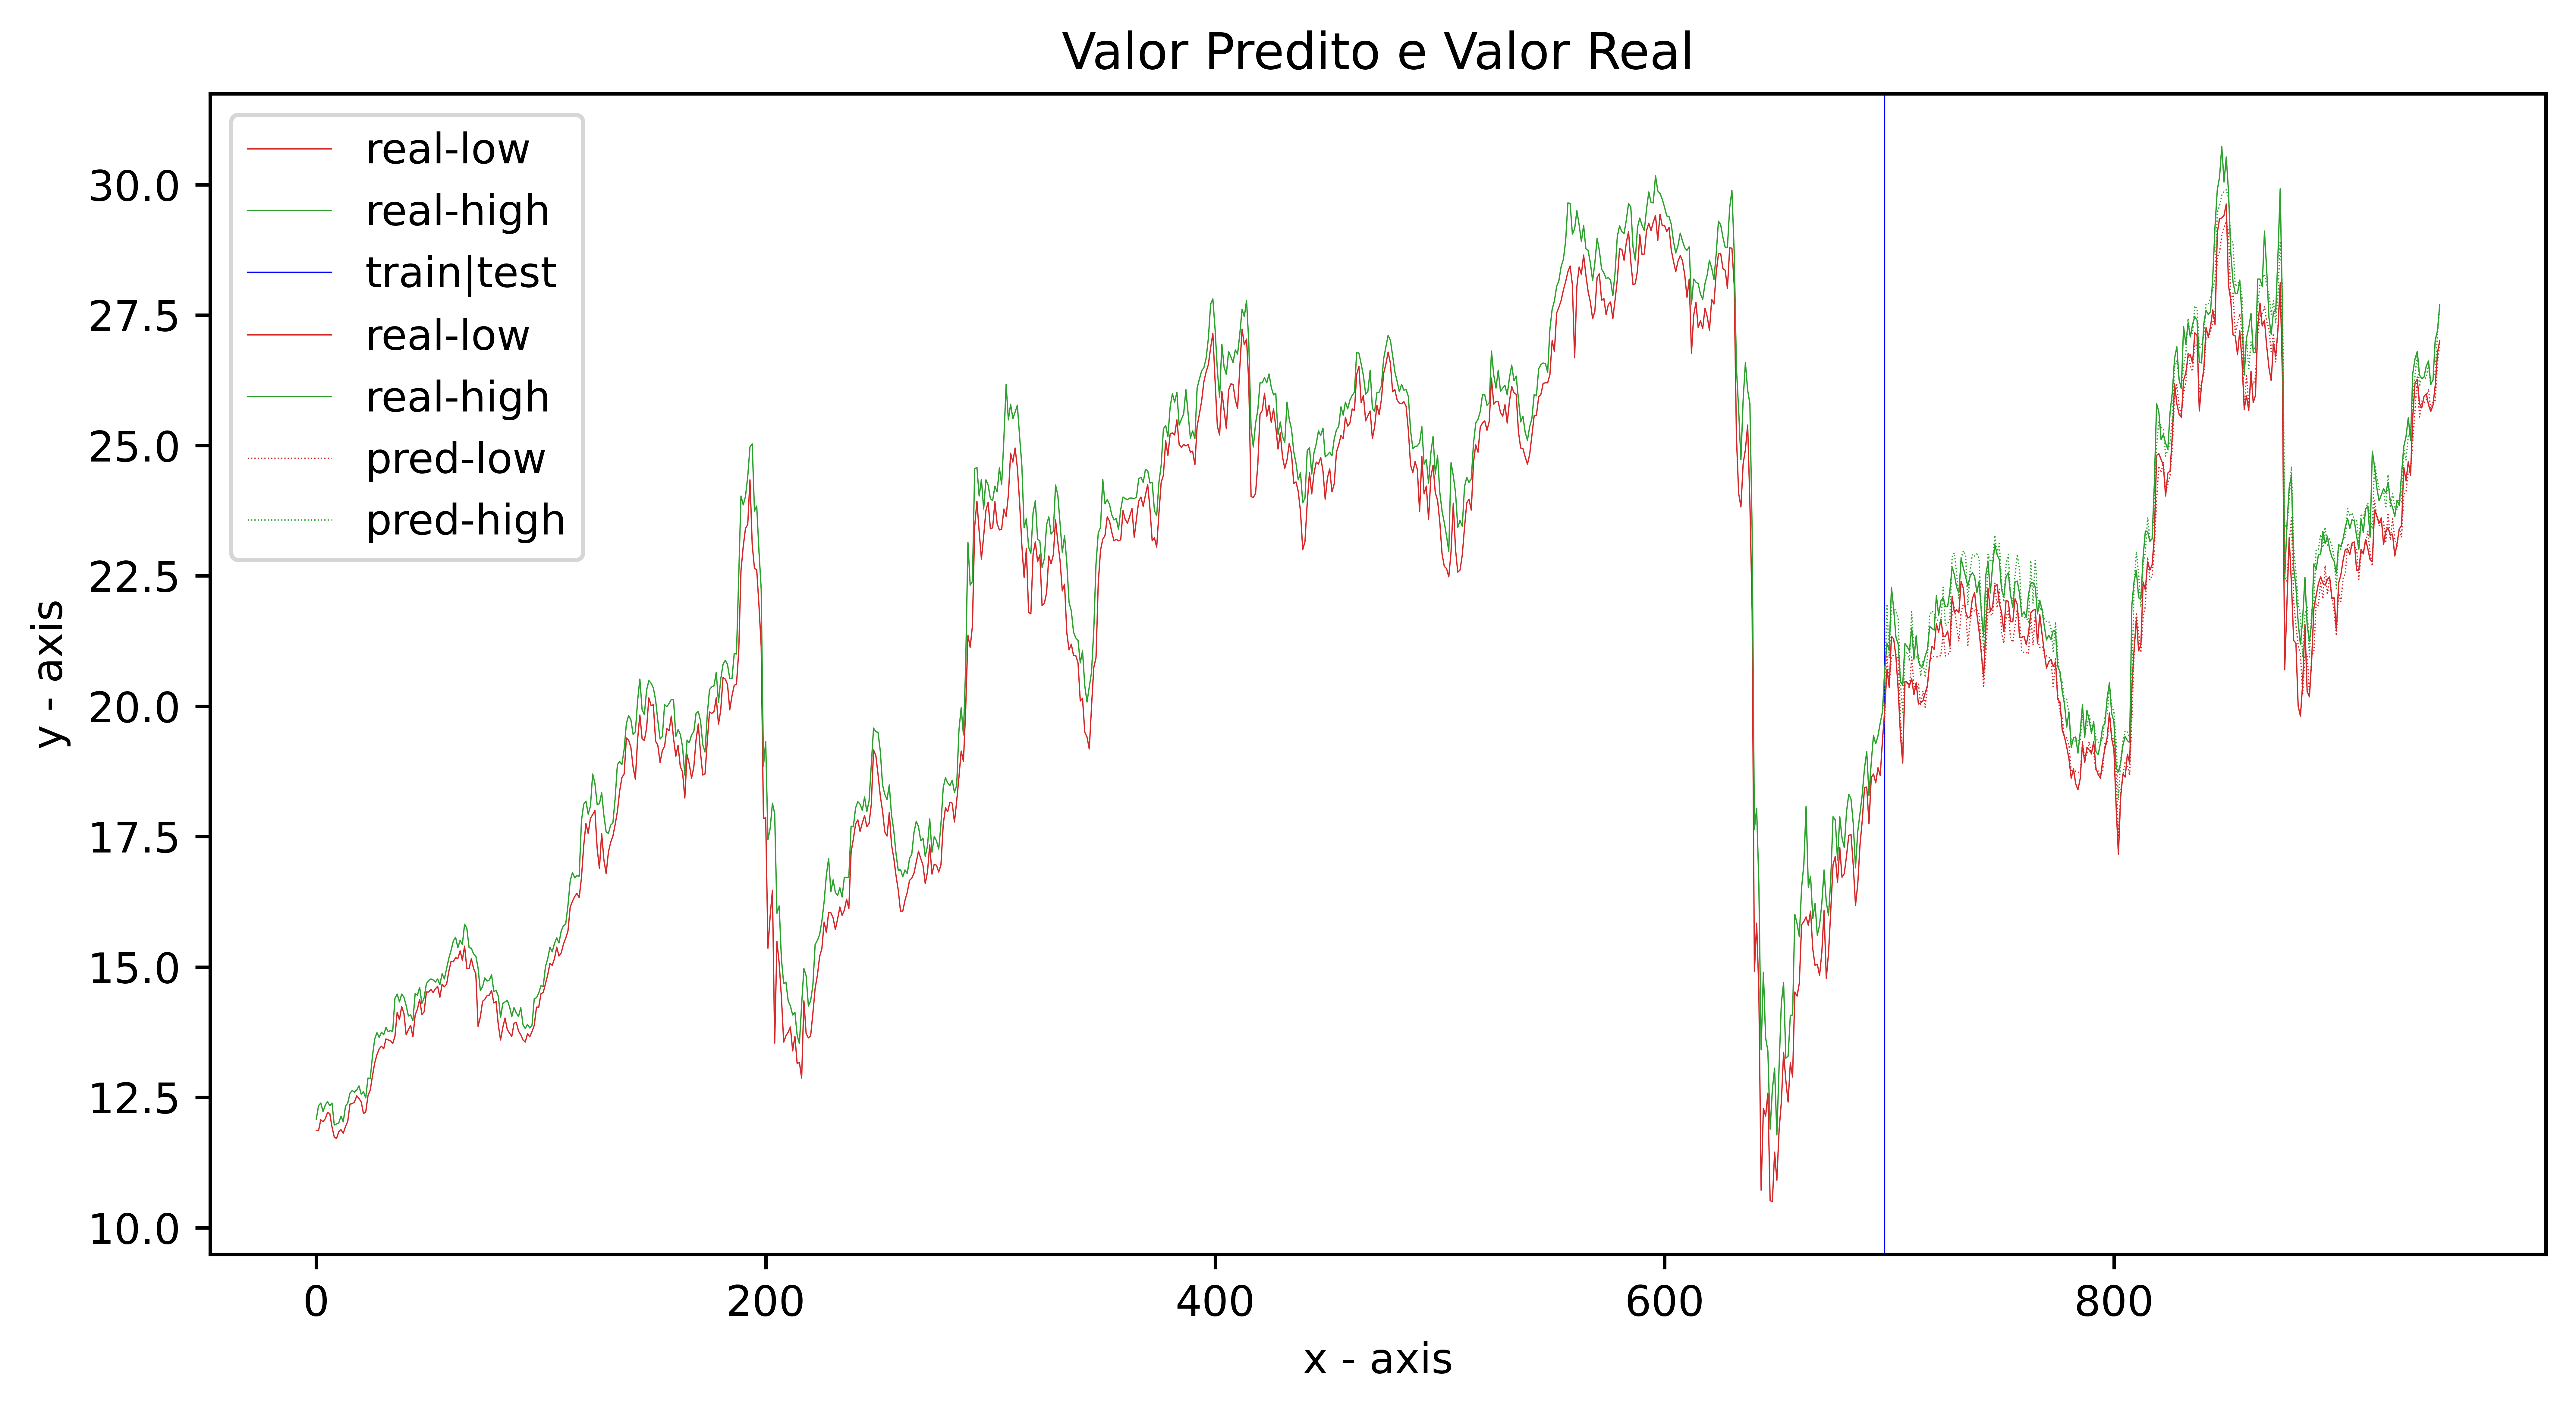

      Feature  Importance
0        open   94.620097
4   EMA_close    1.944924
16  d-1_close    1.565696
3     EMA_low    1.060018
2    EMA_high    0.200573
15    d-1_low    0.094323
19    d-2_low    0.060700
17   d-2_open    0.056292
14   d-1_high    0.051376
12   LB_close    0.040686
8     LB_high    0.034578
10     LB_low    0.024011
6     LB_open    0.022692
9      UB_low    0.020893
11   UB_close    0.019911
5     UB_open    0.019662
7     UB_high    0.017319
13   d-1_open    0.014628
1    EMA_open    0.013465
20  d-2_close    0.011928
26   d-4_high    0.010431
18   d-2_high    0.010202
25   d-4_open    0.010177
22   d-3_high    0.010004
24  d-3_close    0.009067
30   d-5_high    0.008105
21   d-3_open    0.007776
23    d-3_low    0.007596
29   d-5_open    0.007109
31    d-5_low    0.006718
27    d-4_low    0.006433
32  d-5_close    0.006388
28  d-4_close    0.006225


In [47]:
_,_,rf,xTrainColumns, dataFrameTeste = exp1(initialDf_PETR4, printPredictValues=True)

featureImp = []
for feat, importance in zip(xTrainColumns, rf.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (fT_df.sort_values('Importance', ascending = False))

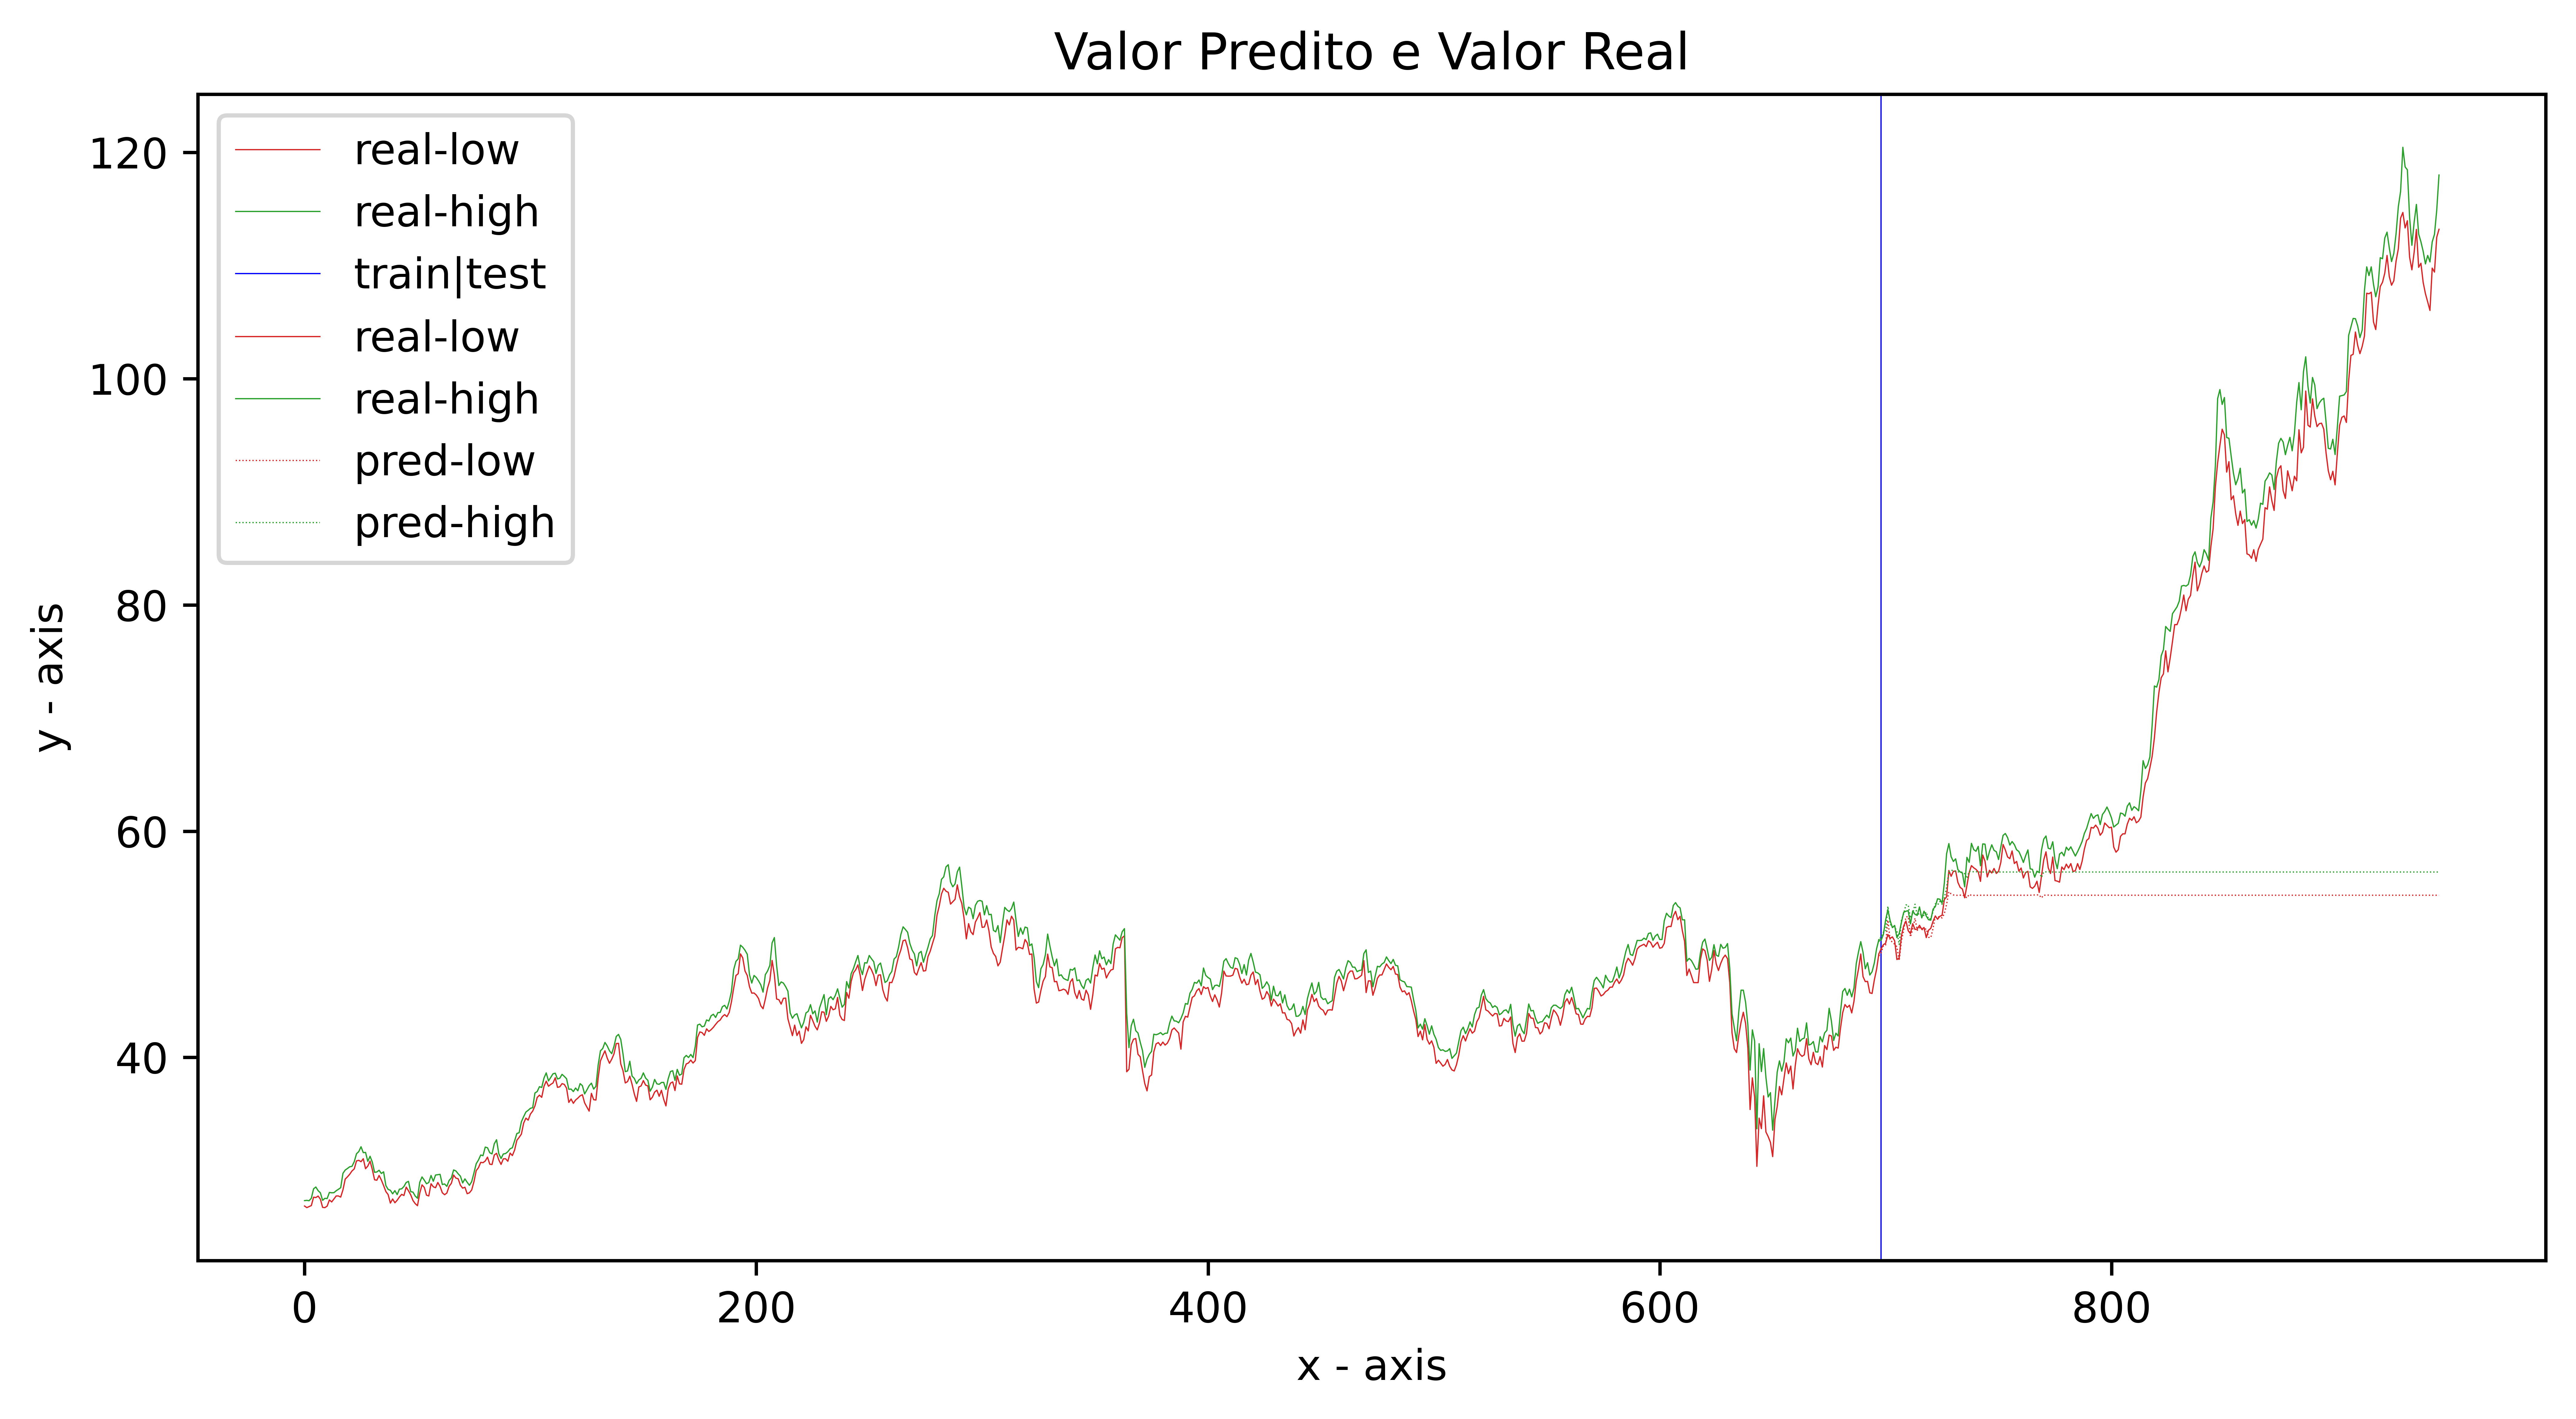

      Feature  Importance
0        open   92.402426
4   EMA_close    2.995135
3     EMA_low    1.595896
16  d-1_close    0.649800
15    d-1_low    0.543027
13   d-1_open    0.178749
11   UB_close    0.131213
24  d-3_close    0.127986
17   d-2_open    0.121982
14   d-1_high    0.118302
7     UB_high    0.110323
9      UB_low    0.094636
5     UB_open    0.089403
18   d-2_high    0.077390
2    EMA_high    0.075090
31    d-5_low    0.073798
22   d-3_high    0.067680
23    d-3_low    0.067588
1    EMA_open    0.066757
28  d-4_close    0.059229
21   d-3_open    0.049009
29   d-5_open    0.048844
12   LB_close    0.034566
32  d-5_close    0.033264
10     LB_low    0.030569
19    d-2_low    0.028436
27    d-4_low    0.026140
26   d-4_high    0.024021
8     LB_high    0.017658
20  d-2_close    0.017050
30   d-5_high    0.016838
6     LB_open    0.016531
25   d-4_open    0.010669


In [46]:
_,_,rf,xTrainColumns, dataFrameTeste = exp1(initialDf_VALE3, printPredictValues=True)

featureImp = []
for feat, importance in zip(xTrainColumns, rf.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (fT_df.sort_values('Importance', ascending = False))

In [13]:
dataFrameTeste

date   open   high    low  close   EMA_open   EMA_high    EMA_low  \
697  2020.06.01  19.50  19.89  19.35  19.67  19.114789  19.515257  18.833676   
698  2020.06.02  20.08  20.70  19.93  20.70  19.436526  19.910171  19.199117   
699  2020.06.03  21.15  21.20  20.71  20.77  20.007684  20.340114  19.702745   
700  2020.06.04  20.69  21.07  20.36  20.73  20.235123  20.583409  19.921830   
701  2020.06.05  21.57  22.28  21.34  21.38  20.680082  21.148940  20.394553   
..          ...    ...    ...    ...    ...        ...        ...        ...   
941  2021.05.26  25.91  26.18  25.65  26.09  26.114791  26.354219  25.760657   
942  2021.05.27  26.08  26.25  25.77  25.91  26.103194  26.319479  25.763771   
943  2021.05.28  26.20  27.02  26.15  26.99  26.135462  26.552986  25.892514   
944  2021.05.31  26.96  27.20  26.78  26.87  26.410308  26.768657  26.188343   
945  2021.06.01  27.40  27.70  27.01  27.29  26.740206  27.079105  26.462229   

     EMA_close    UB_open  ...  d-4_open  d-4_high  d-4_low  d-4_close  \
697  19.338674  19.963541  ...     19.33     19.44    18.70      19.03   
698  19.792450  20.917675  ...     19.16     19.28    18.53      19.28   
699  20.118300  21.421992  ...     19.05     19.43    18.82      19.13   
700  20.322200  21.470431  ...     18.91     19.68    18.67      19.68   
701  20.674800  21.881503  ...     19.50     19.89    19.35      19.67   
..         ...        ...  ...       ...       ...      ...        ...   
941  26.042263  26.470349  ...     26.15     26.28    25.72      25.93   
942  25.998175  26.471798  ...     26.08     26.31    25.94      25.95   
943  26.328784  27.180120  ...     26.28     26.52    25.99      26.39   
944  26.509189  27.435810  ...     26.48     26.62    25.78      25.84   
945  26.769459  27.826996  ...     25.91     26.18    25.65      26.09   

     d-5_open  d-5_high  d-5_low  d-5_close  pred_low  pred_high  
697     18.85     18.92    18.63      18.85  19.35446   19.88396  
698     19.33     19.44    18.70      19.03  19.75314   20.31402  
699     19.16     19.28    18.53      19.28  20.95848   21.96586  
700     19.05     19.43    18.82      19.13  20.39440   20.92822  
701     18.91     19.68    18.67      19.68  20.94662   21.92884  
..        ...       ...      ...        ...       ...        ...  
941     25.85     26.35    25.80      26.15  25.66628   26.14022  
942     26.15     26.28    25.72      25.93  25.81228   26.25560  
943     26.08     26.31    25.94      25.95  25.86484   26.42034  
944     26.28     26.52    25.99      26.39  26.59650   27.13314  
945     26.48     26.62    25.78      25.84  26.91568   27.62108  

[249 rows x 39 columns]

#### Experimento 02: Utilizando Random Forest com indicadores externos
##### Hipóteses plausíveis de serem testadas

In [14]:
PETR4WithExternalIndex = {}
PETR4WithExternalIndex['PETR4Dolar'] = initialDf_PETR4.merge(df_DOLAR, how='inner', on='date', suffixes=('', '_dolar'))
PETR4WithExternalIndex['PETR4VIX'] = initialDf_PETR4.merge(df_VIX, how='inner', on='date', suffixes=('', '_vix'))
PETR4WithExternalIndex['PETR4BTC'] = initialDf_PETR4.merge(df_BTC, how='inner', on='date', suffixes=('', '_BTC'))
PETR4WithExternalIndex['PETR4BVSP'] = initialDf_PETR4.merge(df_BVSP, how='inner', on='date', suffixes=('', '_BVSP'))



#### Verificando importância do Dólar, VIX, BVSP e BTC no Random Forest Regression

In [15]:
for label in ['PETR4Dolar', 'PETR4VIX', 'PETR4BTC', 'PETR4BVSP']:
    print(f"Analisando influencia da feature {label}")
    bd = PETR4WithExternalIndex[label]
    _,_,rf, trainColumns, _ = exp1(bd)

    # importance = rf.feature_importances_
    featureImp = []
    for feat, importance in zip(trainColumns, rf.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)

    fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
    print (fT_df.sort_values('Importance', ascending = False).head(15))

Analisando influencia da feature PETR4Dolar
      Feature  Importance
0        open   93.402507
4   EMA_close    1.937025
16  d-1_close    1.732953
3     EMA_low    1.305626
2    EMA_high    0.547359
15    d-1_low    0.242068
14   d-1_high    0.221760
1    EMA_open    0.179451
17   d-2_open    0.053393
19    d-2_low    0.051758
6     LB_open    0.020852
12   LB_close    0.017966
10     LB_low    0.017390
8     LB_high    0.017339
11   UB_close    0.017278
Analisando influencia da feature PETR4VIX
      Feature  Importance
0        open   93.837617
16  d-1_close    1.818575
4   EMA_close    1.814961
3     EMA_low    0.955507
2    EMA_high    0.358960
15    d-1_low    0.316628
14   d-1_high    0.199902
1    EMA_open    0.174991
19    d-2_low    0.094186
17   d-2_open    0.047715
12   LB_close    0.030602
8     LB_high    0.021874
11   UB_close    0.020107
6     LB_open    0.020044
13   d-1_open    0.019448
Analisando influencia da feature PETR4BTC
      Feature  Importance
0        open 

## Exportando o regressor

In [16]:
_,_,rf, trainColumns, testResult = exp1(initialDf_PETR4)
testResult

date   open   high    low  close   EMA_open   EMA_high    EMA_low  \
697  2020.06.01  19.50  19.89  19.35  19.67  19.114789  19.515257  18.833676   
698  2020.06.02  20.08  20.70  19.93  20.70  19.436526  19.910171  19.199117   
699  2020.06.03  21.15  21.20  20.71  20.77  20.007684  20.340114  19.702745   
700  2020.06.04  20.69  21.07  20.36  20.73  20.235123  20.583409  19.921830   
701  2020.06.05  21.57  22.28  21.34  21.38  20.680082  21.148940  20.394553   
..          ...    ...    ...    ...    ...        ...        ...        ...   
941  2021.05.26  25.91  26.18  25.65  26.09  26.114791  26.354219  25.760657   
942  2021.05.27  26.08  26.25  25.77  25.91  26.103194  26.319479  25.763771   
943  2021.05.28  26.20  27.02  26.15  26.99  26.135462  26.552986  25.892514   
944  2021.05.31  26.96  27.20  26.78  26.87  26.410308  26.768657  26.188343   
945  2021.06.01  27.40  27.70  27.01  27.29  26.740206  27.079105  26.462229   

     EMA_close    UB_open  ...  d-4_open  d-4_high  d-4_low  d-4_close  \
697  19.338674  19.963541  ...     19.33     19.44    18.70      19.03   
698  19.792450  20.917675  ...     19.16     19.28    18.53      19.28   
699  20.118300  21.421992  ...     19.05     19.43    18.82      19.13   
700  20.322200  21.470431  ...     18.91     19.68    18.67      19.68   
701  20.674800  21.881503  ...     19.50     19.89    19.35      19.67   
..         ...        ...  ...       ...       ...      ...        ...   
941  26.042263  26.470349  ...     26.15     26.28    25.72      25.93   
942  25.998175  26.471798  ...     26.08     26.31    25.94      25.95   
943  26.328784  27.180120  ...     26.28     26.52    25.99      26.39   
944  26.509189  27.435810  ...     26.48     26.62    25.78      25.84   
945  26.769459  27.826996  ...     25.91     26.18    25.65      26.09   

     d-5_open  d-5_high  d-5_low  d-5_close  pred_low  pred_high  
697     18.85     18.92    18.63      18.85  19.34820   19.88562  
698     19.33     19.44    18.70      19.03  19.76170   20.30714  
699     19.16     19.28    18.53      19.28  20.96824   22.01234  
700     19.05     19.43    18.82      19.13  20.39716   20.93800  
701     18.91     19.68    18.67      19.68  20.94918   21.98674  
..        ...       ...      ...        ...       ...        ...  
941     25.85     26.35    25.80      26.15  25.68248   26.13200  
942     26.15     26.28    25.72      25.93  25.83120   26.26642  
943     26.08     26.31    25.94      25.95  25.84650   26.41108  
944     26.28     26.52    25.99      26.39  26.58916   27.13546  
945     26.48     26.62    25.78      25.84  26.92772   27.62574  

[249 rows x 39 columns]

In [17]:
initialDf_PETR4

date   open   high    low  close   EMA_open   EMA_high    EMA_low  \
0    2017.08.01  12.06  12.08  11.86  11.90  11.941241  12.016120  11.797504   
1    2017.08.02  11.91  12.34  11.86  12.25  11.930827  12.124080  11.818336   
2    2017.08.03  12.31  12.39  12.07  12.07  12.057218  12.212720  11.902224   
3    2017.08.04  12.16  12.23  12.03  12.15  12.091479  12.218480  11.944816   
4    2017.08.07  12.11  12.35  12.09  12.29  12.097653  12.262320  11.993211   
..          ...    ...    ...    ...    ...        ...        ...        ...   
941  2021.05.26  25.91  26.18  25.65  26.09  26.114791  26.354219  25.760657   
942  2021.05.27  26.08  26.25  25.77  25.91  26.103194  26.319479  25.763771   
943  2021.05.28  26.20  27.02  26.15  26.99  26.135462  26.552986  25.892514   
944  2021.05.31  26.96  27.20  26.78  26.87  26.410308  26.768657  26.188343   
945  2021.06.01  27.40  27.70  27.01  27.29  26.740206  27.079105  26.462229   

     EMA_close    UB_open  ...  d-3_low  d-3_close  d-4_open  d-4_high  \
0    11.901463  12.108321  ...    11.79      11.79     12.06     12.10   
1    12.017642  12.333836  ...    11.71      11.91     11.84     11.94   
2    12.035095  12.321517  ...    11.85      12.05     11.77     11.91   
3    12.073397  12.343075  ...    11.86      11.90     11.99     12.07   
4    12.145598  12.443256  ...    11.86      12.25     12.06     12.08   
..         ...        ...  ...      ...        ...       ...       ...   
941  26.042263  26.470349  ...    25.94      25.95     26.15     26.28   
942  25.998175  26.471798  ...    25.99      26.39     26.08     26.31   
943  26.328784  27.180120  ...    25.78      25.84     26.28     26.52   
944  26.509189  27.435810  ...    25.65      26.09     26.48     26.62   
945  26.769459  27.826996  ...    25.77      25.91     25.91     26.18   

     d-4_low  d-4_close  d-5_open  d-5_high  d-5_low  d-5_close  
0      11.77      11.77     11.80     12.02    11.80      11.99  
1      11.79      11.79     12.06     12.10    11.77      11.77  
2      11.71      11.91     11.84     11.94    11.79      11.79  
3      11.85      12.05     11.77     11.91    11.71      11.91  
4      11.86      11.90     11.99     12.07    11.85      12.05  
..       ...        ...       ...       ...      ...        ...  
941    25.72      25.93     25.85     26.35    25.80      26.15  
942    25.94      25.95     26.15     26.28    25.72      25.93  
943    25.99      26.39     26.08     26.31    25.94      25.95  
944    25.78      25.84     26.28     26.52    25.99      26.39  
945    25.65      26.09     26.48     26.62    25.78      25.84  

[946 rows x 37 columns]

Brute Return: 114270.0
Annual Return:14.28
Max DD: 11.18
Mean Trades: 1.49
#####################################
Media de lucro em casos de trades corretos: 0.3017204301075268
Media de prejuízos em casos de trades errados: -0.08629496402877708
Accuracy( percentagem das operações que tiveram lucros): 25.0


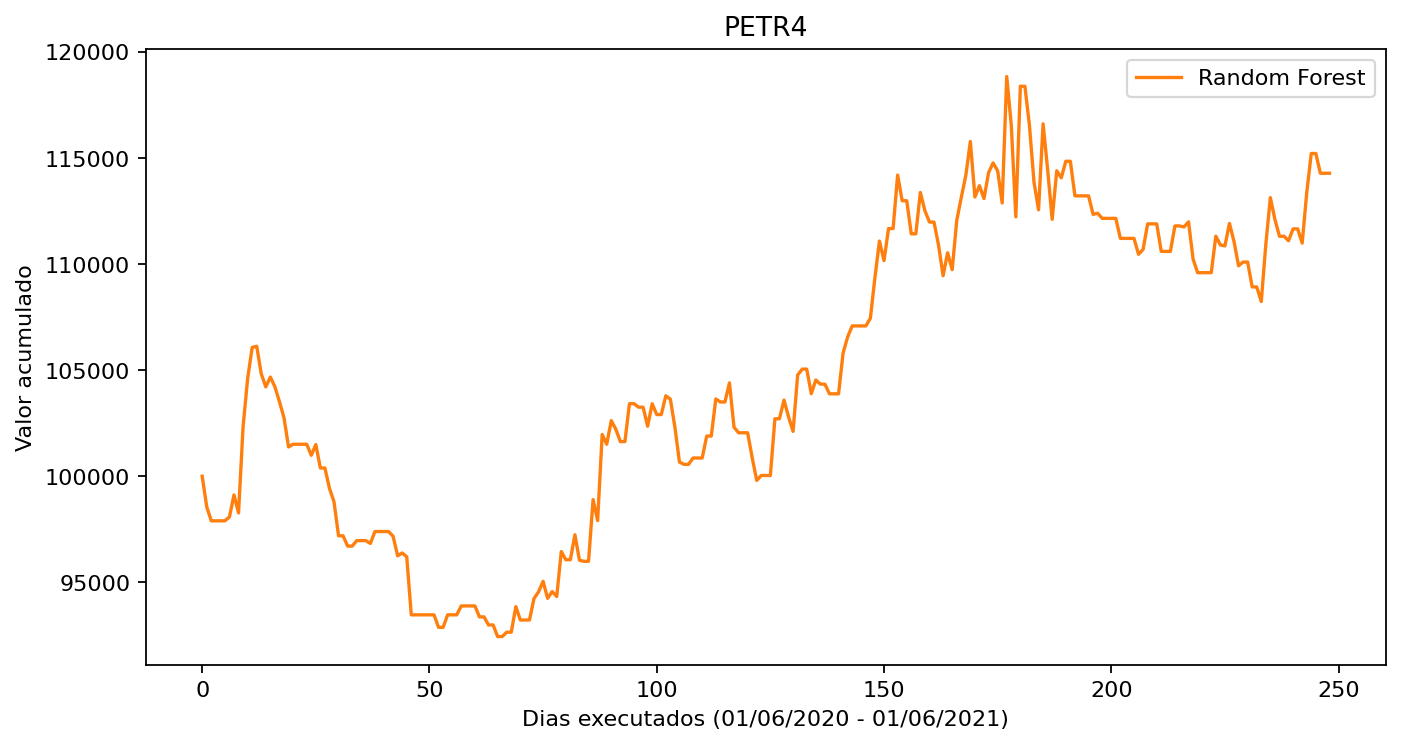

In [24]:
import sys
try:
    del sys.modules["utils"]
except: pass
try:
    del sys.modules["traderSystem"]
except: pass
from utils import exportRegressor, importRegressor
from traderSystem import runStrategy, printStrategyResult, printAmountChart

# rfPath = './myFirstModel.joblib'
# exportRegressor(rf, rfPath)

dfColumns = ['date','time','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']

PETR_df_M15 = pd.read_csv('../Data/PETR4_M15.csv', sep = "\t")
PETR_df_M15.columns = dfColumns
PETR_df_M15 = removeColumns(PETR_df_M15, ['tickvol', 'volume','spread'])
PETR_df_M15['time'] = PETR_df_M15['time'].apply(lambda x: x[:-3])

errorMax, errorMin,rf, trainColumns, testResult = exp1(initialDf_PETR4)
# orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0.02, 0.02)
orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(
    df=testResult, 
    dailyDf=PETR_df_M15,
    Money=100000,
    stopLoss=0.001,
    errorMax=None,
    errorMin=None,
    stdMax=None,
    stdMin=None,
    alfa=0.0,
    beta=0.0,
    method='martinez'
    )

printStrategyResult(finalMoney, annualReturn, DDmax, tradesMean)
printAmountChart(orders, dfDaily)


Se escolhermos E_max +  teta_max = 0.34 e E_min +  teta_min = 0.24 conforme encontrado nas células acima, então  o resultado fica igual ao do TCC de Adrion
- runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0.34, 0.24) 

Brute Return: 227168.0
Annual Return:127.3
Max DD: 8.97
Mean Trades: 2.69
#####################################
Media de lucro em casos de trades corretos: 0.33235602094240835
Media de prejuízos em casos de trades errados: -0.09023157894736847
Accuracy( percentagem das operações que tiveram lucros): 28.51


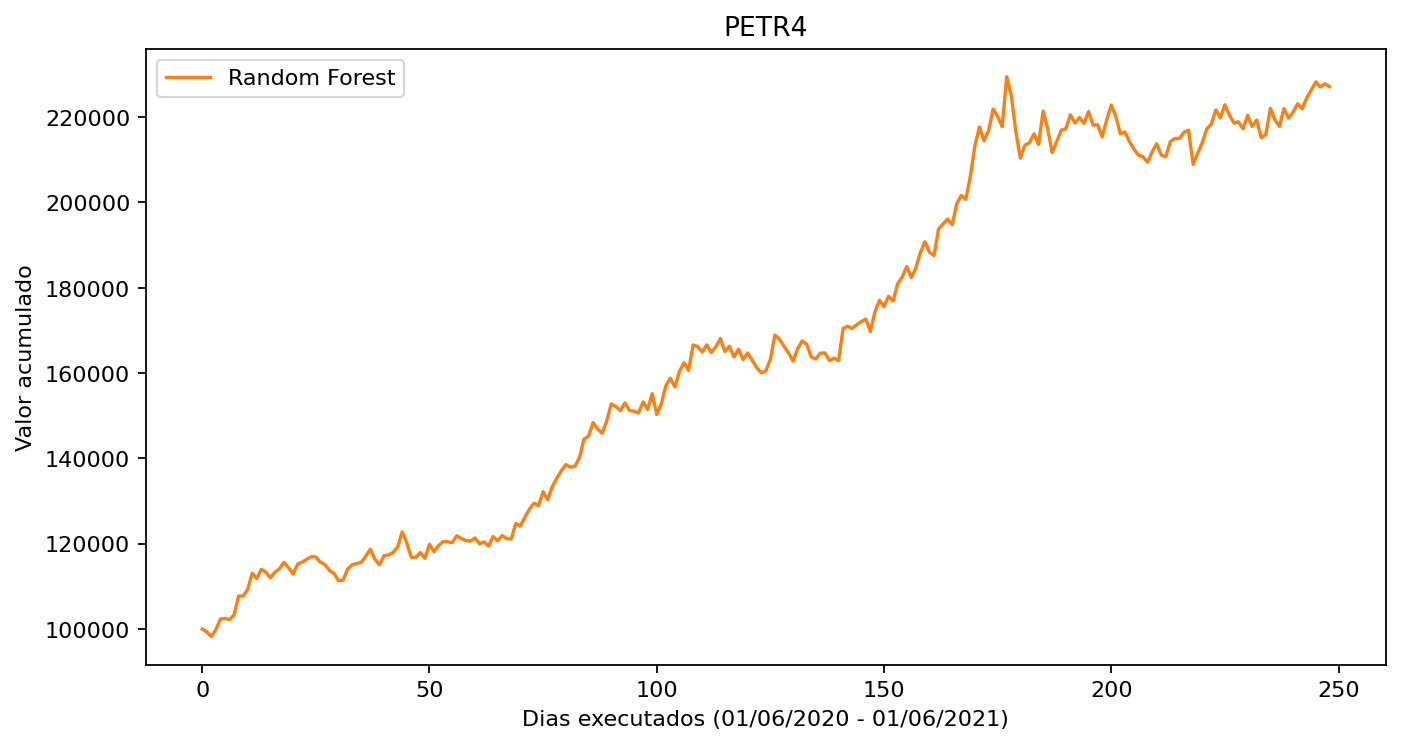

In [25]:
import sys
try:
    del sys.modules["utils"]
except: pass
try:
    del sys.modules["traderSystem"]
except: pass
from utils import exportRegressor, importRegressor
from traderSystem import runStrategy, printStrategyResult, printAmountChart

# rfPath = './myFirstModel.joblib'
# exportRegressor(rf, rfPath)

dfColumns = ['date','time','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']

PETR_df_M15 = pd.read_csv('../Data/PETR4_M15.csv', sep = "\t")
PETR_df_M15.columns = dfColumns
PETR_df_M15 = removeColumns(PETR_df_M15, ['tickvol', 'volume','spread'])
PETR_df_M15['time'] = PETR_df_M15['time'].apply(lambda x: x[:-3])

errorMax, errorMin,rf, trainColumns, testResult = exp1(initialDf_PETR4)
# orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0.02, 0.02)
orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(
    df=testResult, 
    dailyDf=PETR_df_M15,
    Money=100000,
    stopLoss=0.001,
    errorMax=None,
    errorMin=None,
    stdMax=None,
    stdMin=None,
    alfa=0.5,
    beta=0.1,
    method='martinez'
    )

printStrategyResult(finalMoney, annualReturn, DDmax, tradesMean)
printAmountChart(orders, dfDaily)


Brute Return: 127758.0
Annual Return:27.78
Max DD: 14.87
Mean Trades: 8.29
#####################################
Media de lucro em casos de trades corretos: 0.07071065989847707
Media de prejuízos em casos de trades errados: -0.06815126050420166
Accuracy( percentagem das operações que tiveram lucros): 47.72


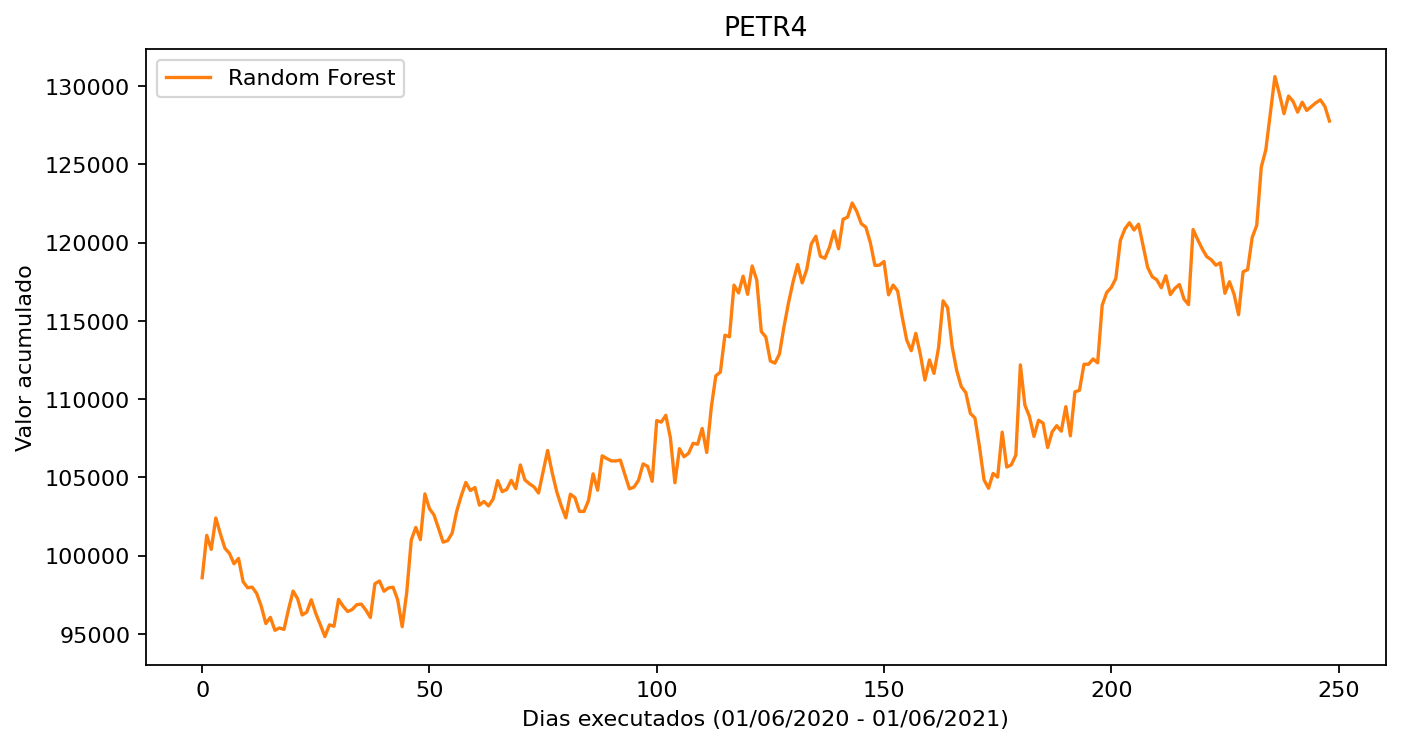

In [30]:
import sys
try:
    del sys.modules["utils"]
except: pass
try:
    del sys.modules["traderSystem"]
except: pass
from utils import exportRegressor, importRegressor
from traderSystem import runStrategy, printStrategyResult, printAmountChart

# rfPath = './myFirstModel.joblib'
# exportRegressor(rf, rfPath)

dfColumns = ['date','time','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']

PETR_df_M15 = pd.read_csv('../Data/PETR4_M15.csv', sep = "\t")
PETR_df_M15.columns = dfColumns
PETR_df_M15 = removeColumns(PETR_df_M15, ['tickvol', 'volume','spread'])
PETR_df_M15['time'] = PETR_df_M15['time'].apply(lambda x: x[:-3])

errorMax, errorMin,rf, trainColumns, testResult = exp1(initialDf_PETR4)
# orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(testResult, PETR_df_M15, 100000, 0.001, 0.02, 0.02)
orders, dfDaily, DD, DDmax, annualReturn, finalMoney, tradesMean = runStrategy(
    df=testResult, 
    dailyDf=PETR_df_M15,
    Money=100000,
    stopLoss=0.001,
    errorMax=0.34,
    errorMin=0.25,
    stdMax=0.01,
    stdMin=0.0,
    alfa=None,
    beta=None,
    method='adrion'
    )

printStrategyResult(finalMoney, annualReturn, DDmax, tradesMean)
printAmountChart(orders, dfDaily)
